In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -U scikit-learn
!pip install numpy
!pip install matplotlib
!pip install keras

import numpy as np
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, Flatten, LSTM, Bidirectional
import tensorflow as tf
from sklearn.metrics import classification_report

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 24.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
import pandas as pd

mydata = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/IMDB_Dataset.csv") #loading dataset
print(mydata) #printing the loaded dataset

backup = mydata.copy()

                                                  review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]


<Axes: ylabel='sentiment'>

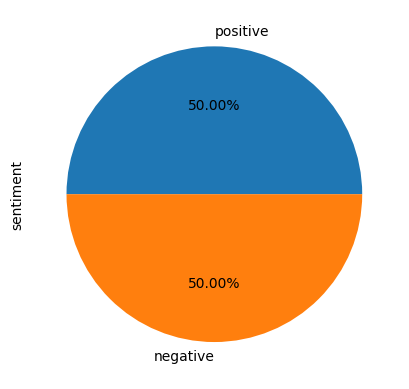

In [ ]:
# Checking the Condition of Dataset

piechart = mydata['sentiment'].value_counts()
mydata['sentiment'].value_counts().plot(kind="pie",autopct='%.2f%%')

In [ ]:
# Checking for unique data

print(f'Total number of reviews:',len(mydata['review']))
print(f'Unique number of reviews:',len(mydata['review'].unique()))

Total number of reviews: 50000
Unique number of reviews: 49582


In [ ]:
# Removing duplicate data

udata = mydata.drop_duplicates(subset = 'review')
print(f'Total reviews after removing duplicates:',len(udata['review'].unique()))
print(f'Unique labels for the reviews:', udata['sentiment'].unique())

Total reviews after removing duplicates: 49582
Unique labels for the reviews: ['positive' 'negative']


In [ ]:
# Preparing the Data

column1 = udata['review']
column2 = udata['sentiment']

review = []
sentiment = []

for eachrow in column1:
  review.append(eachrow)         # review is a list containing all the texts

for eachrow in column2:
  if eachrow == 'positive':
    sentiment.append(1)
  else:
    sentiment.append(0)         # sentiment is the list containing all the labels of the corresponding texts

In [ ]:
# Tokenizing

max_features = 10000
padding = 256

tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(review)                        #tokenizing our review data
sequences = tokenizer.texts_to_sequences(review)

vocab = tokenizer.word_index
print("Unique Tokens found:", len(vocab))

r_data = pad_sequences(sequences, maxlen=padding)
#print(r_data)

s_data = np.asarray(sentiment)
print("Shape of review data tensor:", r_data.shape)
print("Shape of sentiment data tensor:", s_data.shape)

Unique Tokens found: 124252
Shape of review data tensor: (49582, 256)
Shape of sentiment data tensor: (49582,)


In [ ]:
# Creating our Embedding Dictionary using GloVe

embedding_file_path = '/content/drive/MyDrive/Colab Notebooks/Conversion_model/glove.6B.100d.txt'  # Opening the GloVe file

embedding_dic= {}
glove = open(embedding_file_path, encoding='utf-8')

for line in glove:
  values = line.split()
  word = values[0]
  vector = np.asarray(values[1:], dtype='float32')
  embedding_dic[word] = vector

glove.close()

print("GloVe has", len(embedding_dic), "word vectors. So does our Embedding Dictionary!")

GloVe has 400000 word vectors. So does our Embedding Dictionary!


In [ ]:
# Our Data Conversion: From texts into vectors using the Embedding Dictionary

embedding_dim = 100

embedding_matrix = np.zeros((max_features, embedding_dim))

for word, vec in vocab.items():
  embedding_vector = embedding_dic.get(word)
  if vec < max_features:
    if embedding_vector is not None:
      embedding_matrix[vec] = embedding_vector

print(embedding_matrix.shape)

(10000, 100)


In [ ]:
# Splitting Review (x-input) and Sentiment (y-output) Data in two parts: Train and Test

x_train, x_test, y_train, y_test = train_test_split(r_data , s_data, train_size=0.80, random_state = 66) # 80% training, 20% testing

print("Shape of our input train data is", x_train.shape , "and that of output is", y_train.shape)
print("Shape of our input test data is", x_test.shape , "and that of output is", y_test.shape)

Shape of our input train data is (39665, 256) and that of output is (39665,)
Shape of our input test data is (9917, 256) and that of output is (9917,)


In [ ]:
# Designing our 3-Layered Shallow Model

model1 = Sequential()
model1.add(Embedding(max_features, embedding_dim, input_length = padding, weights=[embedding_matrix], trainable=False))
model1.add(Flatten())
model1.add(Dense(10, activation='tanh'))
model1.add(Dropout(0.4))
model1.add(Dense(1, activation='sigmoid'))

model1.summary()

METRICS = [tf.keras.metrics.BinaryAccuracy(),
           tf.keras.metrics.Precision(name="precision"),
           tf.keras.metrics.Recall(name="recall")]

model1.compile(loss='binary_crossentropy', optimizer='adam', metrics = METRICS)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 100)          1000000   
                                                                 
 flatten (Flatten)           (None, 25600)             0         
                                                                 
 dense (Dense)               (None, 10)                256010    
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1256021 (4.79 MB)
Trainable params: 256021 (1000.08 KB)
Non-trainable params: 1000000 (3.81 MB)
_________________________________________________________________


In [ ]:
# Training our Shallow Model

history1 = model1.fit(x_train, y_train,
                    epochs = 20,
                    batch_size = 100,
                    validation_data = (x_test, y_test))

Epoch 1/20
397/397 [==============================] - 6s 6ms/step - loss: 0.7982 - binary_accuracy: 0.5056 - precision: 0.5102 - recall: 0.4918 - val_loss: 0.6844 - val_binary_accuracy: 0.5820 - val_precision: 0.5567 - val_recall: 0.7404
Epoch 2/20
397/397 [==============================] - 2s 5ms/step - loss: 0.6935 - binary_accuracy: 0.5661 - precision: 0.5650 - recall: 0.6070 - val_loss: 0.6167 - val_binary_accuracy: 0.6788 - val_precision: 0.6392 - val_recall: 0.7980
Epoch 3/20
397/397 [==============================] - 3s 7ms/step - loss: 0.6033 - binary_accuracy: 0.6822 - precision: 0.6840 - recall: 0.6874 - val_loss: 0.5793 - val_binary_accuracy: 0.7130 - val_precision: 0.7670 - val_recall: 0.5989
Epoch 4/20
397/397 [==============================] - 3s 7ms/step - loss: 0.5601 - binary_accuracy: 0.7219 - precision: 0.7234 - recall: 0.7263 - val_loss: 0.5530 - val_binary_accuracy: 0.7342 - val_precision: 0.7220 - val_recall: 0.7480
Epoch 5/20
397/397 [============================

In [ ]:
# Checking Performance Matrices for Shallow Model

performance1 = model1.evaluate(x_test, y_test, return_dict=True)
print(performance1)
print()
pred1 = model1.predict(x_test)
print()
for i in range(len(pred1)):
    if(pred1[i] > 0.5):
        pred1[i] = 1
    else:
        pred1[i] = 0

print(classification_report(y_test, pred1))

310/310 [==============================] - 1s 3ms/step - loss: 0.5949 - binary_accuracy: 0.7420 - precision: 0.7001 - recall: 0.8322
{'loss': 0.5948578715324402, 'binary_accuracy': 0.7419582605361938, 'precision': 0.7001034021377563, 'recall': 0.8322064876556396}

310/310 [==============================] - 1s 2ms/step

              precision    recall  f1-score   support

           0       0.80      0.65      0.72      5036
           1       0.70      0.83      0.76      4881

    accuracy                           0.74      9917
   macro avg       0.75      0.74      0.74      9917
weighted avg       0.75      0.74      0.74      9917



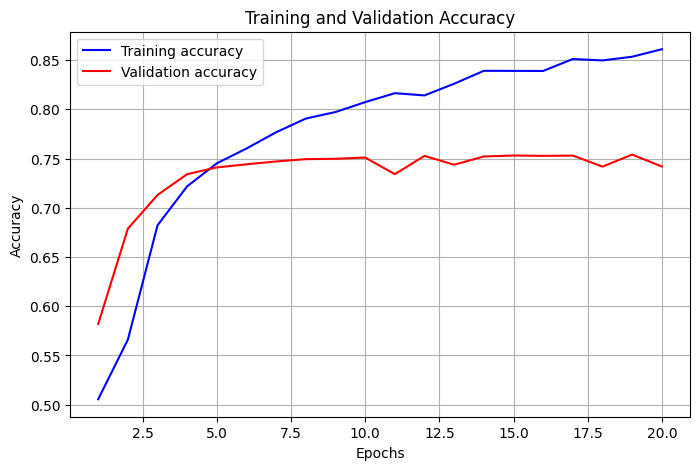

In [ ]:
# Plotting Training and Validation Accuracy

training_accuracy = history1.history['binary_accuracy']
validation_accuracy = history1.history['val_binary_accuracy']
epochs = range(1, len(training_accuracy) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, training_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Designing our 3-Layered Unidirectional LSTM Model

model2 = Sequential()
model2.add(Embedding(max_features, embedding_dim, input_length = padding, weights=[embedding_matrix], trainable=False))
model2.add(LSTM(10, dropout = 0.3))
model2.add(Dense(1, activation='sigmoid'))

model2.summary()

METRICS = [tf.keras.metrics.BinaryAccuracy(),
           tf.keras.metrics.Precision(name="precision"),
           tf.keras.metrics.Recall(name="recall")]

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics = METRICS)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 256, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 10)                4440      
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1004451 (3.83 MB)
Trainable params: 4451 (17.39 KB)
Non-trainable params: 1000000 (3.81 MB)
_________________________________________________________________


In [ ]:
# Training our Unidirectional LSTM Model

history2 = model2.fit(x_train, y_train,
                    epochs = 20,
                    batch_size = 200,
                    validation_data = (x_test, y_test))

Epoch 1/20
199/199 [==============================] - 7s 23ms/step - loss: 0.6433 - binary_accuracy: 0.6245 - precision: 0.6236 - recall: 0.6443 - val_loss: 0.5688 - val_binary_accuracy: 0.7104 - val_precision: 0.6557 - val_recall: 0.8668
Epoch 2/20
199/199 [==============================] - 3s 17ms/step - loss: 0.5307 - binary_accuracy: 0.7462 - precision: 0.7439 - recall: 0.7574 - val_loss: 0.4824 - val_binary_accuracy: 0.7839 - val_precision: 0.7525 - val_recall: 0.8359
Epoch 3/20
199/199 [==============================] - 3s 14ms/step - loss: 0.4664 - binary_accuracy: 0.7904 - precision: 0.7863 - recall: 0.8026 - val_loss: 0.4513 - val_binary_accuracy: 0.7964 - val_precision: 0.7415 - val_recall: 0.9002
Epoch 4/20
199/199 [==============================] - 3s 14ms/step - loss: 0.4369 - binary_accuracy: 0.8011 - precision: 0.7969 - recall: 0.8129 - val_loss: 0.4154 - val_binary_accuracy: 0.8148 - val_precision: 0.7683 - val_recall: 0.8928
Epoch 5/20
199/199 [========================

In [ ]:
# Checking Performance Metrices for Unidirrectional LSTM

performance2 = model2.evaluate(x_test, y_test, return_dict=True)
print(performance2)
print()
pred2 = model2.predict(x_test)
print()
for i in range(len(pred2)):
    if(pred2[i] > 0.5):
        pred2[i] = 1
    else:
        pred2[i] = 0

print(classification_report(y_test, pred2))

310/310 [==============================] - 2s 7ms/step - loss: 0.3139 - binary_accuracy: 0.8637 - precision: 0.8295 - recall: 0.9101
{'loss': 0.31394240260124207, 'binary_accuracy': 0.8636684417724609, 'precision': 0.8295051455497742, 'recall': 0.91005939245224}

310/310 [==============================] - 2s 5ms/step

              precision    recall  f1-score   support

           0       0.90      0.82      0.86      5036
           1       0.83      0.91      0.87      4881

    accuracy                           0.86      9917
   macro avg       0.87      0.86      0.86      9917
weighted avg       0.87      0.86      0.86      9917



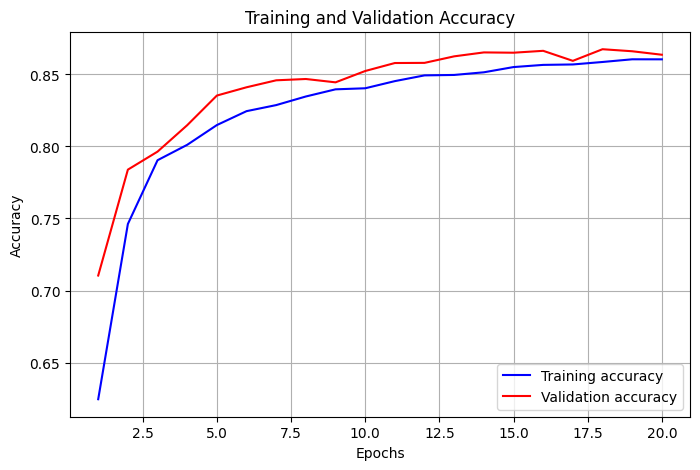

In [ ]:
# Plotting Training and Validation Accuracy

training_accuracy = history2.history['binary_accuracy']
validation_accuracy = history2.history['val_binary_accuracy']
epochs = range(1, len(training_accuracy) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, training_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Designing our 3-Layered Bidirectional LSTM Model

model3 = Sequential()
model3.add(Embedding(max_features, embedding_dim, input_length = padding, weights=[embedding_matrix], trainable=False))
model3.add(Bidirectional(LSTM(10, dropout=0.1)))
model3.add(Dense(1, activation='sigmoid'))

model3.summary()

METRICS = [tf.keras.metrics.BinaryAccuracy(),
           tf.keras.metrics.Precision(name="precision"),
           tf.keras.metrics.Recall(name="recall")]

model3.compile(loss='binary_crossentropy', optimizer='adam', metrics = METRICS)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 256, 100)          1000000   
                                                                 
 bidirectional (Bidirection  (None, 20)                8880      
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1008901 (3.85 MB)
Trainable params: 8901 (34.77 KB)
Non-trainable params: 1000000 (3.81 MB)
_________________________________________________________________


In [ ]:
# Training our Bidirectional LSTM Model

history3 = model3.fit(x_train, y_train,
                    epochs = 20,
                    batch_size = 200,
                    validation_data = (x_test, y_test))

Epoch 1/20
199/199 [==============================] - 12s 29ms/step - loss: 0.6448 - binary_accuracy: 0.6282 - precision: 0.6336 - recall: 0.6229 - val_loss: 0.5701 - val_binary_accuracy: 0.7258 - val_precision: 0.7194 - val_recall: 0.7261
Epoch 2/20
199/199 [==============================] - 5s 25ms/step - loss: 0.5928 - binary_accuracy: 0.6992 - precision: 0.7029 - recall: 0.6988 - val_loss: 0.5993 - val_binary_accuracy: 0.7023 - val_precision: 0.6668 - val_recall: 0.7898
Epoch 3/20
199/199 [==============================] - 6s 30ms/step - loss: 0.5703 - binary_accuracy: 0.7157 - precision: 0.7272 - recall: 0.6981 - val_loss: 0.5302 - val_binary_accuracy: 0.7468 - val_precision: 0.7198 - val_recall: 0.7951
Epoch 4/20
199/199 [==============================] - 5s 24ms/step - loss: 0.6428 - binary_accuracy: 0.6514 - precision: 0.6316 - recall: 0.7406 - val_loss: 0.6228 - val_binary_accuracy: 0.6838 - val_precision: 0.6540 - val_recall: 0.7591
Epoch 5/20
199/199 [=======================

In [ ]:
# Checking Performance Metrices for Bidirrectional LSTM

performance3 = model3.evaluate(x_test, y_test, return_dict=True)
print(performance3)
print()
pred3 = model3.predict(x_test)
print()
for i in range(len(pred3)):
    if(pred3[i] > 0.5):
        pred3[i] = 1
    else:
        pred3[i] = 0

print(classification_report(y_test, pred3))

310/310 [==============================] - 3s 11ms/step - loss: 0.3287 - binary_accuracy: 0.8568 - precision: 0.8508 - recall: 0.8599
{'loss': 0.32873648405075073, 'binary_accuracy': 0.8568115234375, 'precision': 0.8508007526397705, 'recall': 0.8598647713661194}

310/310 [==============================] - 4s 9ms/step

              precision    recall  f1-score   support

           0       0.86      0.85      0.86      5036
           1       0.85      0.86      0.86      4881

    accuracy                           0.86      9917
   macro avg       0.86      0.86      0.86      9917
weighted avg       0.86      0.86      0.86      9917



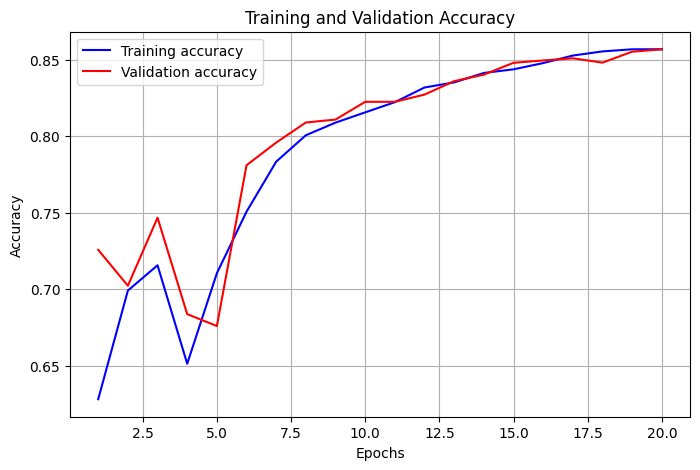

In [ ]:
# Plotting Training and Validation Accuracy

training_accuracy = history3.history['binary_accuracy']
validation_accuracy = history3.history['val_binary_accuracy']
epochs = range(1, len(training_accuracy) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, training_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
tf.keras.backend.clear_session()